# Inicio
Se descarga la data del dataset de Mendeley y procedemos a guardarla en una carpeta llamada RAW_ECG_DATASET

In [1]:
!wget https://data.mendeley.com/public-files/datasets/7dybx7wyfn/files/854dd691-aad3-4793-af3b-6142d1ec8a2a/file_downloaded -O dataset_ecg.zip

--2026-01-15 15:15:40--  https://data.mendeley.com/public-files/datasets/7dybx7wyfn/files/854dd691-aad3-4793-af3b-6142d1ec8a2a/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/503a174a-a723-4aaa-86f2-9483e7412a77 [following]
--2026-01-15 15:15:41--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/503a174a-a723-4aaa-86f2-9483e7412a77
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.64.214, 52.92.19.154, 3.5.69.6, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.64.214|:443... conn

In [2]:
!unzip dataset_ecg.zip -d ./RAW_ECG_DATASET

Archive:  dataset_ecg.zip
   creating: ./RAW_ECG_DATASET/MLII/
   creating: ./RAW_ECG_DATASET/MLII/1 NSR/
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/100m (0).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/100m (1).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/100m (2).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/100m (3).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/100m (4).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/100m (5).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/100m (6).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/100m (7).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/100m (8).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/100m (9).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/101m (0).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/101m (1).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/101m (10).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/101m (2).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 NSR/101m (3).mat  
  inflating: ./RAW_ECG_DATASET/MLII/1 

Comenzamos a leer la data

In [4]:
import os
import re
import pickle
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm

PATH = "RAW_ECG_DATASET/MLII/"
OUTPUT_FILE = "ecg_mlii_dataset.pkl"

FS = 360                # frecuencia de muestreo
LEAD = "MLII"
SIGNAL_KEY = "val"      # key dentro del .mat


def extract_label(folder_name):
    """
    Extrae el nombre de la clase desde '16 SDHB' → 'SDHB'
    """
    return re.findall(r'(\d+)\s+(.*)', folder_name)[0][1]


def load_ecg_folder(folder_path):
    """
    Carga todos los .mat de una carpeta y devuelve
    un array (N, 3600)
    """
    signals = []

    files = sorted(os.listdir(folder_path))
    for file in files:
        if file.endswith(".mat"):
            mat = loadmat(os.path.join(folder_path, file))
            signal = mat[SIGNAL_KEY][0]   # (3600,)
            signals.append(signal)

    return np.array(signals, dtype=np.int16)


data_by_class = {}
class_sizes = {}

folders = sorted(os.listdir(PATH))

for folder in tqdm(folders, desc="Procesando clases"):
    folder_path = os.path.join(PATH, folder)

    if not os.path.isdir(folder_path):
        continue

    label = extract_label(folder)
    signals = load_ecg_folder(folder_path)

    data_by_class[label] = signals
    class_sizes[label] = signals.shape[0]



metadata = {
    "dataset_name": "MIT-BIH Arrhythmia Database",
    "lead": LEAD,
    "sampling_rate": FS,
    "signal_length": 3600,
    "n_classes": len(data_by_class),
    "classes": list(data_by_class.keys()),
    "class_distribution": class_sizes,
    "signal_dtype": "int16",
    "preprocessing": "none",
    "source_path": PATH
}


dataset = {
    "data": data_by_class,
    "metadata": metadata
}

with open(OUTPUT_FILE, "wb") as f:
    pickle.dump(dataset, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Data guardada correctamente")
print(f"Archivo: {OUTPUT_FILE}")
print(f"Clases: {metadata['classes']}")


Procesando clases: 100%|██████████| 17/17 [00:00<00:00, 75.59it/s]

✅ Dataset organizado y guardado correctamente
📦 Archivo: ecg_mlii_dataset.pkl
🧠 Clases: ['NSR', 'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW', 'PVC', 'Bigeminy', 'Trigeminy']


## Usando el archivo tipo pickle guardado

Se guardó la información del dataset en un archivo tipo pickle

In [5]:
with open("ecg_mlii_dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

data = dataset["data"]
metadata = dataset["metadata"]

print(metadata["class_distribution"])



{'NSR': 283, 'VT': 10, 'IVR': 10, 'VFL': 10, 'Fusion': 11, 'LBBBB': 103, 'RBBBB': 62, 'SDHB': 10, 'PR': 45, 'APB': 66, 'AFL': 20, 'AFIB': 135, 'SVTA': 13, 'WPW': 21, 'PVC': 133, 'Bigeminy': 55, 'Trigeminy': 13}


## Distribución de señales



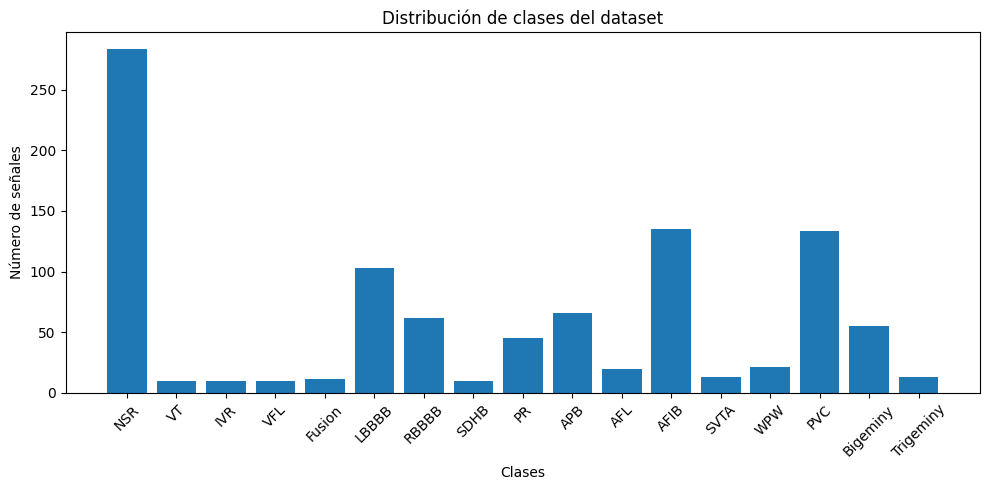

In [18]:
class_distribution = metadata["class_distribution"]

classes = list(class_distribution.keys())
counts = list(class_distribution.values())

plt.figure(figsize=(10, 5))
plt.bar(classes, counts)
plt.xlabel("Clases")
plt.ylabel("Número de señales")
plt.title("Distribución de clases del dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

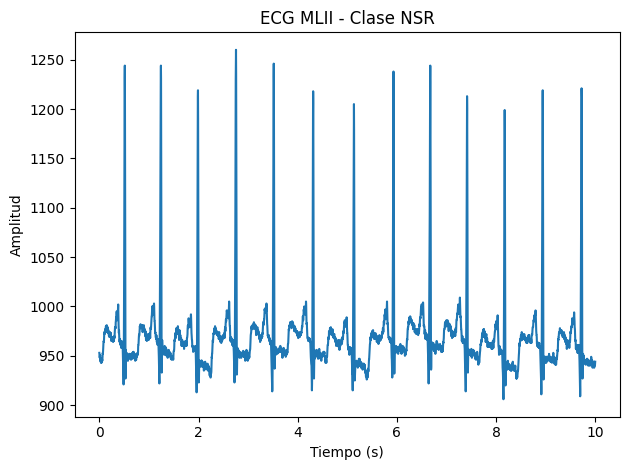

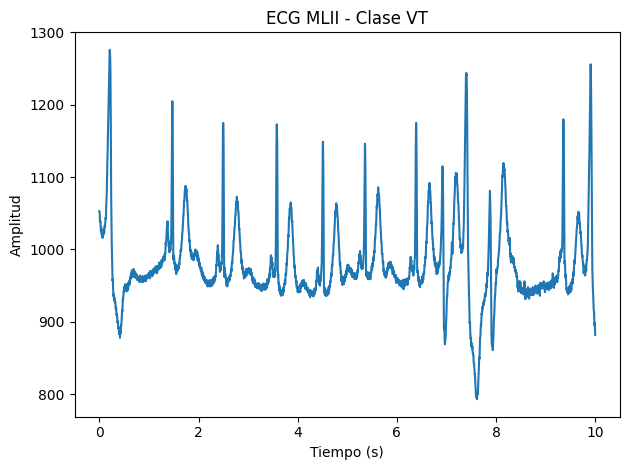

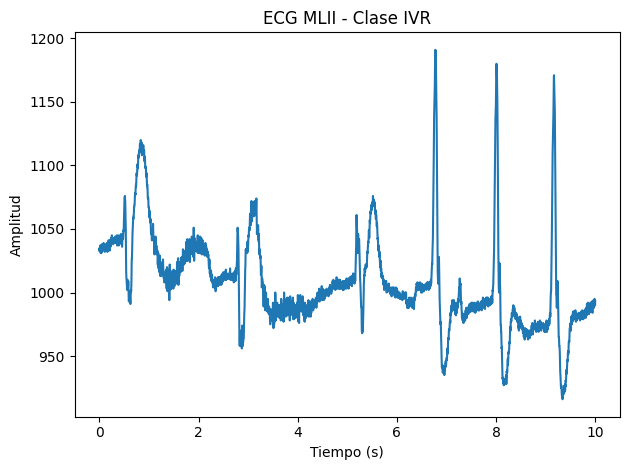

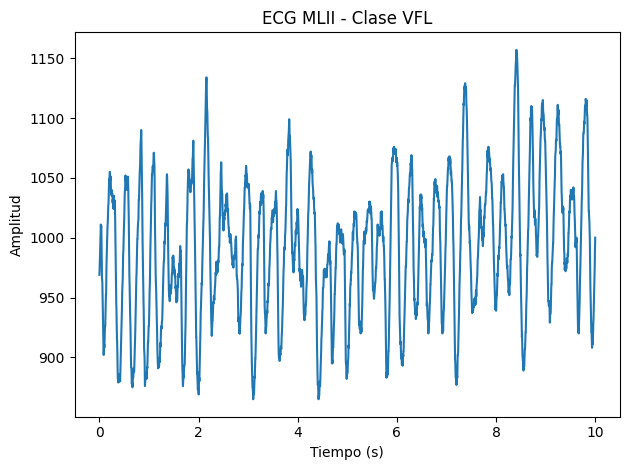

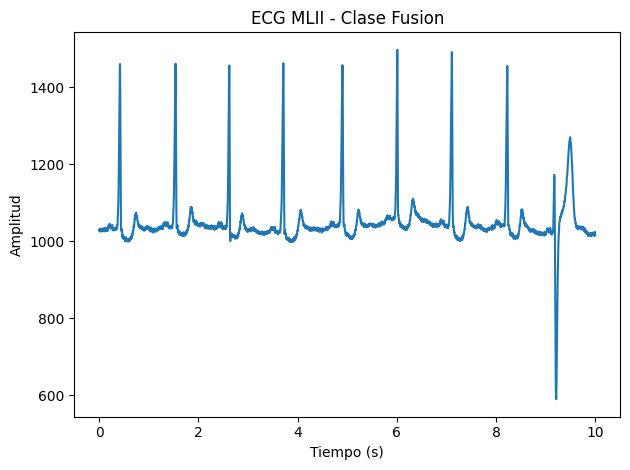

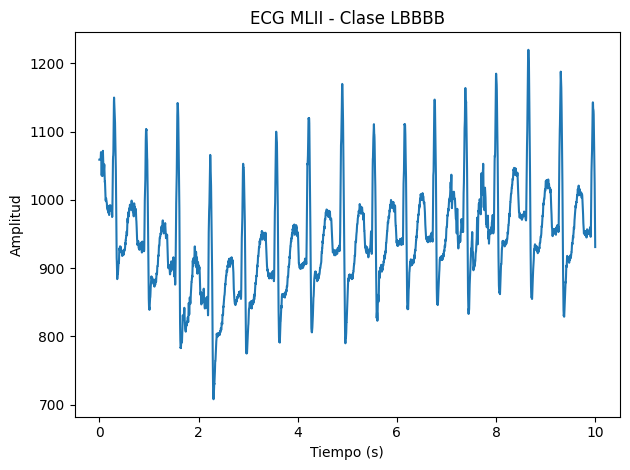

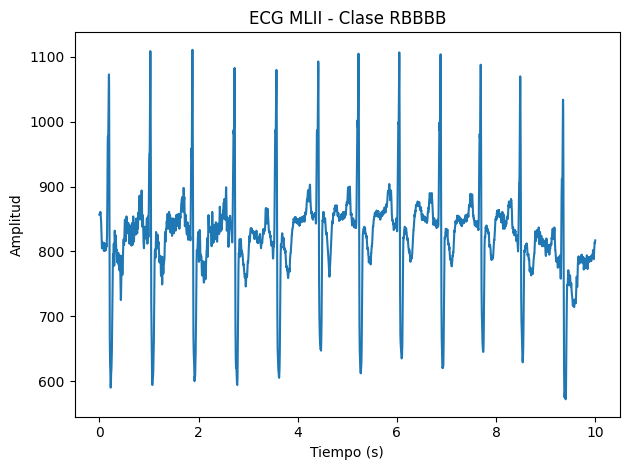

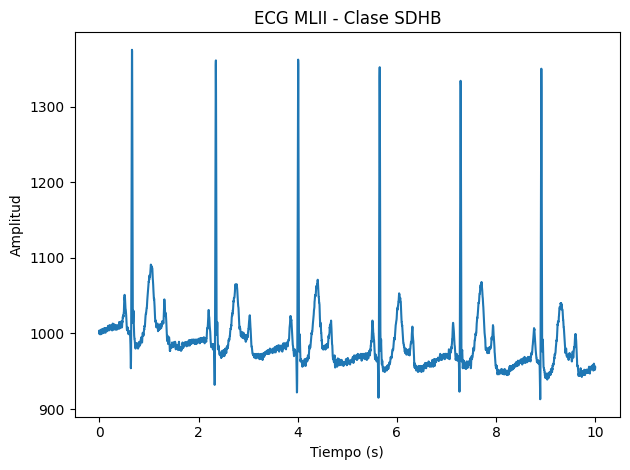

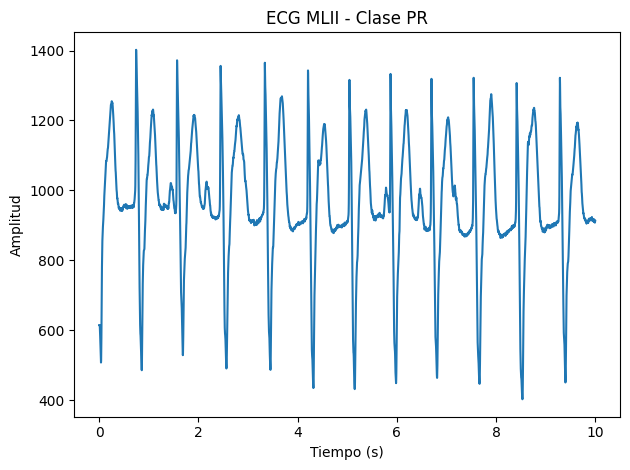

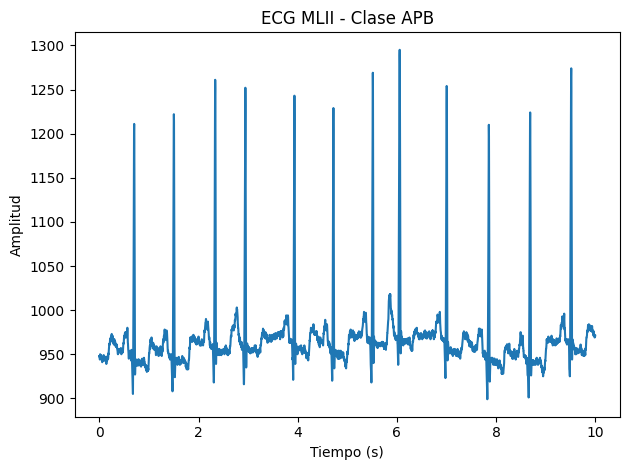

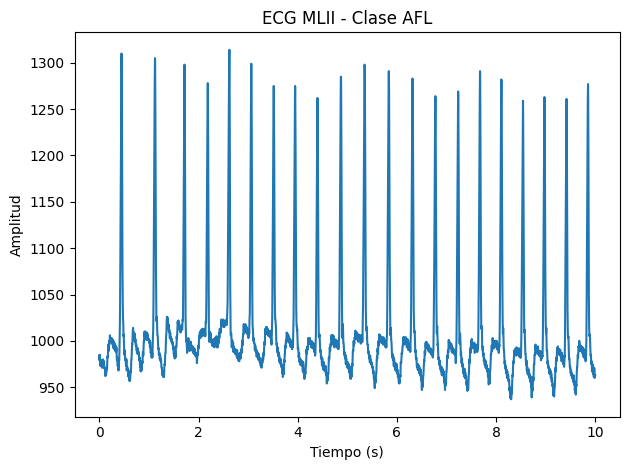

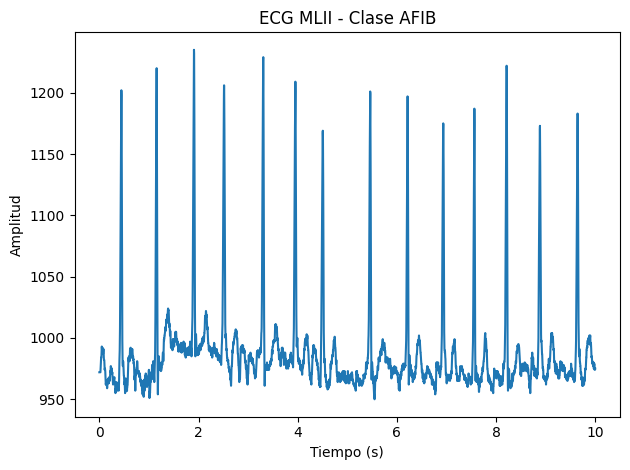

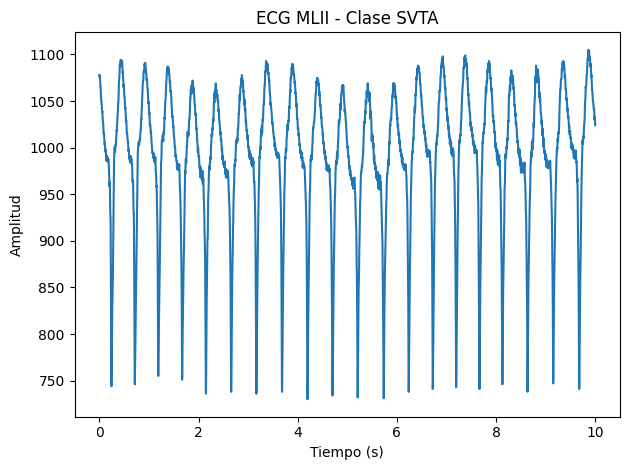

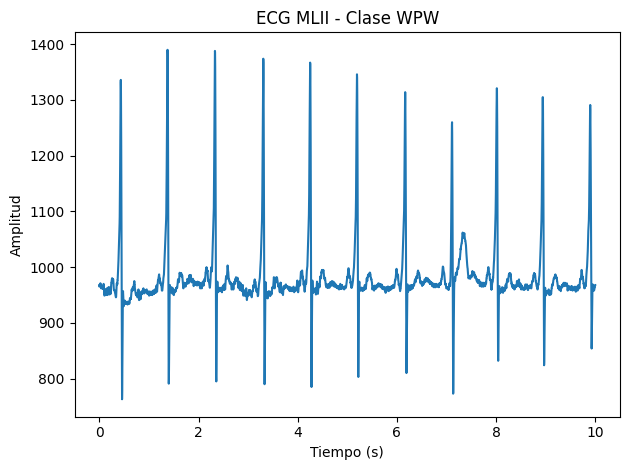

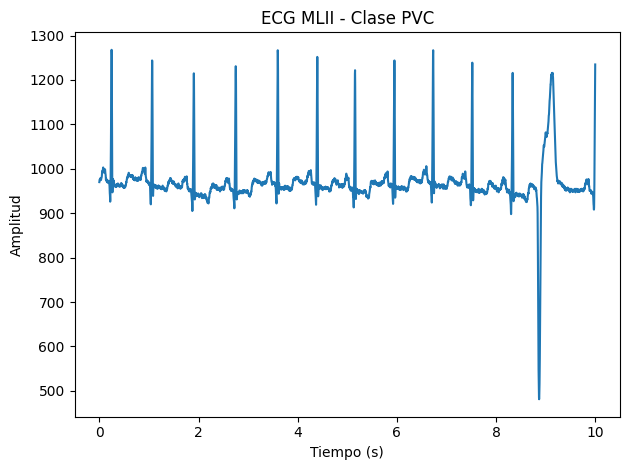

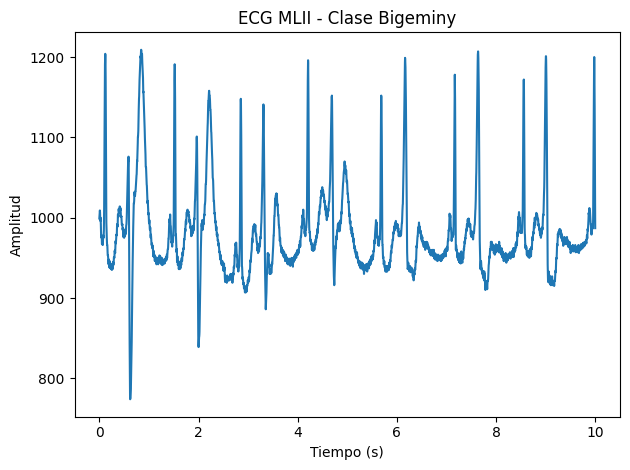

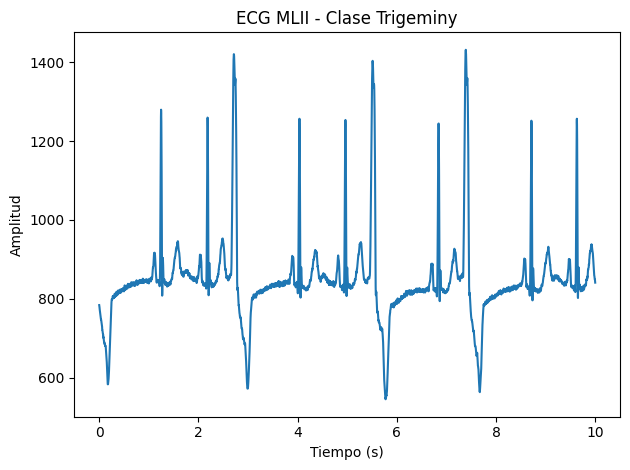

In [20]:
fs = metadata["sampling_rate"]

for label, signals in data.items():
    signal = signals[0]  # primera señal de la clase
    t = np.arange(signal.shape[0]) / fs

    plt.figure()
    plt.plot(t, signal)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.title(f"ECG MLII - Clase {label}")
    plt.tight_layout()
    plt.show()

### Graficando señales

Primero para la NSR



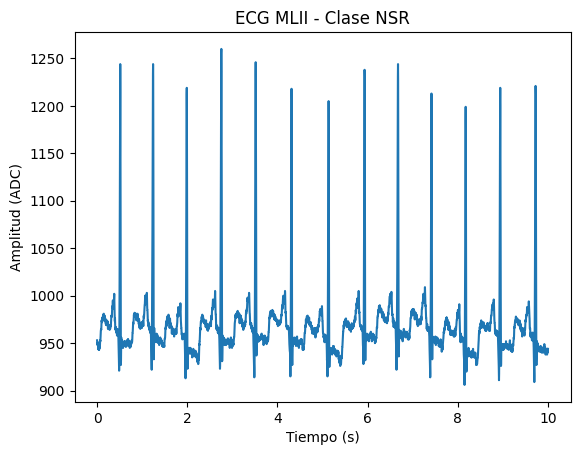

In [15]:
import matplotlib.pyplot as plt

X_nsr = data["NSR"]

fs = metadata["sampling_rate"]  # 360 Hz
n_samples = X_nsr.shape[1]      # 3600

t = np.arange(n_samples) / fs

signal = X_nsr[0]

plt.figure()
plt.plot(t, signal)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (ADC)")
plt.title("ECG MLII - Clase NSR")
plt.show()

In [9]:
X_snr = data["NSR"]
X_snr


array([[ 953,  951,  949, ...,  940,  943,  944],
       [ 915,  927,  934, ...,  965,  963,  962],
       [ 989,  984,  981, ...,  949,  949,  952],
       ...,
       [ 975,  976,  975, ...,  996,  993,  990],
       [1045, 1043, 1043, ...,  984,  982,  979],
       [ 921,  922,  921, ...,  996,  995,  995]], dtype=int16)

## Procesamiento

Luego viene el procesamiento de las señales